In [1]:
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import warnings  # Handling warnings
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold

#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV 

# 🤐 Disable warnings to keep the code clean
warnings.filterwarnings("ignore")
# simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# 📊 Define flags and variables
# is_offline = False  # Flag for online/offline mode
is_train = True  # Flag for training mode
is_infer = True
# max_lookback = np.nan  # Maximum lookback (not specified)
split_day = 435  # Split day for time series data

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")
# 🧹 Remove rows with missing values in the "target" column
df = df.dropna(subset=["target"])

# 🔁 Reset the index of the DataFrame and apply the changes in place
df.reset_index(drop=True, inplace=True)
df = reduce_mem_usage(df)
print("Shape of df: ", df.shape)

Mem. usage decreased to 234.78 Mb (65.4% reduction)
Shape of df:  (5237892, 17)


# Feature Engineering

In [4]:
def feature_eng(data):
    drop_cols = []
    if 'row_id' in data.columns:
        drop_cols.append('row_id')
    if 'time_id' in data.columns:
        drop_cols.append('time_id')
    df=data.drop(drop_cols, axis=1)
    df['trade_volume'] = df['bid_size'] + df['ask_size']
    df['trade_volume_diff'] = df['bid_size'] - df['ask_size']
    df['imbalance_ratio_1'] = df['imbalance_size'] / df['trade_volume']
    df['imbalance_ratio_2'] = df['imbalance_size'] / df['trade_volume_diff']
    df['imbalance_ratio_3'] = df['imbalance_size'] / df['matched_size']
    
    # stock trading price max, min, std, med
    # trading volume max, min, std, med
    # diff price vs med
    # diff trading volume vs med
    stats_cols = [
        'trade_volume', 'wap', 'reference_price', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size'
    ]
    df_by_stock = df[stats_cols+['stock_id']].groupby('stock_id').agg(['min', 'max', 'mean', 'std'])
    df_by_stock.columns = ["_".join(x) for x in df_by_stock.columns.ravel()]
    df = df.merge(df_by_stock, on='stock_id', how='left')
    for col in [x for x in stats_cols if 'price' in x]:
        df['wap_' + col+'_'+'diff'] = df['wap']-df[col]
        df[col+'_mean_diff'] = df[col] - df[col+'_mean']
        df[col+'_mean_diff_normed'] = df[col+'_mean_diff']/df[col+'_std']
    
    for col in ['wap', 'trade_volume', 'bid_size', 'ask_size']:
        df[col +'_mean_diff'] = df[col] - df[col+'_mean']
        df[col+'_mean_diff_normed'] = df[col+'_mean_diff'] / df[col+'_std']

    # avg/diff for same day and stock
    day_cols = stats_cols + ['imbalance_size', 'matched_size']
    df_by_stock_date = df[day_cols+['stock_id','date_id']].groupby(['stock_id', 'date_id']).mean()
    df_by_stock_date.columns = [x+'_day_mean' for x in day_cols]
    fst_by_stock_date = (df[day_cols+['stock_id','date_id', 'seconds_in_bucket']]
                         .sort_values(['stock_id','date_id', 'seconds_in_bucket'])
                         .groupby(['stock_id', 'date_id']).first()
                        )
    fst_by_stock_date.columns.values[:-1] = [x+'_day_start' for x in day_cols]
    df = (df
          .merge(fst_by_stock_date, on=['stock_id','date_id'], how='left')
          .merge(df_by_stock_date, on=['stock_id','date_id'], how='left')
         )
    for col in day_cols:
        df[col+'_diff_start'] = df[col] - df[col+'_day_start']
        df[col+'_diff_day_mean'] = df[col] - df[col+'_day_mean']
    return df

In [5]:
feature_df = feature_eng(df)
feature_df.drop('target', axis=1, inplace=True)

# Train test split

In [6]:
if is_train:
    X_train, X_test, y_train, y_test = train_test_split(
        feature_df, df['target'], test_size=0.2, random_state=42, stratify=feature_df['stock_id'])
    print("X train:", X_train.shape)
    print("X test:", X_test.shape)
    print("y train:", y_train.shape)
    print("y test:", y_test.shape)
    print("unique stock ids train:", X_train['stock_id'].nunique())
    print("unique stock ids test:", X_test['stock_id'].nunique())

X train: (4190313, 123)
X test: (1047579, 123)
y train: (4190313,)
y test: (1047579,)
unique stock ids train: 200
unique stock ids test: 200


## Hyperparameter Optimization

In [7]:
# hyperparameter optimization
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate, num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'objective': 'regression', 'metric':'mae'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)

        cv_result = lgb.cv(
            params, train_data, nfold=n_folds, seed=random_seed, stratified=False, metrics=['l1']
        )
        return max(cv_result['l1-mean'])

    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)


    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.

    lgbBO.maximize(init_points=init_round, n_iter=opt_round)

    model_mae=[]
    for model in range(len(lgbBO.res)):
        model_mae.append(lgbBO.res[model]['target'])

    # return best parameters
    return lgbBO.res[pd.Series(model_mae).idxmin()]['target'],lgbBO.res[pd.Series(model_mae).idxmin()]['params']

if is_train:
    opt_params = bayes_parameter_opt_lgb(
        X_train, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000
    )

    opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
    opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
    opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
    opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
    opt_params[1]['objective']='regression'
    opt_params[1]['metric']='mae'

    # k fold, best model
    print(opt_params)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.801010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the 

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.9963605418316657, subsample=0.2580000042232922 will be ignored. Current value: bagging_fraction=0.9963605418316657
[LightGBM] [Warning] bagging_fraction is set=0.9963605418316657, subsample=0.2580000042232922 will be ignored. Current value: bagging_fraction=0.9963605418316657
[LightGBM] [Warning] bagging_fraction is set=0.9963605418316657, subsample=0.2580000042232922 will be ignored. Current value: bagging_fraction=0.9963605418316657
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.233990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1558
[LightGBM] [Info] Number of data points in the train set: 2793542, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.9963605418316657, subsample=0.2580000042232922 will be ignored. Current value: bagging_fraction=0.9963605418316657
[LightGBM] [Warning] bagging_fraction is set=0.9963605418

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.219994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3182
[LightGBM] [Info] Number of data points in the train set: 2793542, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.9280786928822388, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.9280786928822388
[LightGBM] [Warning] bagging_fraction is set=0.9280786928822388, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.9280786928822388
[LightGBM] [Warning] bagging_fraction is set=0.9280786928822388, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.9280786928822388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.975089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 2793542, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.9280786928822388, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.9280786928822388
[LightGBM] [Warning] bagging_fraction is set=0.92807869288223

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.734906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1204
[LightGBM] [Info] Number of data points in the train set: 2793542, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, s

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.8333129803667263, subsample=0.2623276224265793 will be ignored. Current value: bagging_fraction=0.8333129803667263
[LightGBM] [Warning] bagging_fraction is set=0.8333129803667263, subsample=0.2623276224265793 will be ignored. Current value: bagging_fraction=0.8333129803667263
[LightGBM] [Warning] bagging_fraction is set=0.8333129803667263, subsample=0.2623276224265793 will be ignored. Current value: bagging_fraction=0.8333129803667263
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.301614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2959
[LightGBM] [Info] Number of data points in the train set: 2793542, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.8333129803667263, subsample=0.2623276224265793 will be ignored. Current value: bagging_fraction=0.8333129803667263
[LightGBM] [Warning] bagging_fraction is set=0.8333129803

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.372317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3532
[LightGBM] [Info] Number of data points in the train set: 2793542, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0

[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.565570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3532
[LightGBM] [Info] Number of data points in the train set: 2793542, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.276256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 609
[LightGBM] [Info] Number of data points in the train set: 2793542, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.662403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3532
[LightGBM] [Info] Number of data points in the train set: 2793542, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0

[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.360552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3532
[LightGBM] [Info] Number of data points in the train set: 2793542, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.613129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 609
[LightGBM] [Info] Number of data points in the train set: 2793542, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[Lig

In [8]:
if is_train:
    folds = KFold(n_splits=5, shuffle=True, random_state=6)
    preds = np.zeros(len(y_train))
    predictions = np.zeros(len(y_test))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        print("Fold {}".format(fold_))
        trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
        val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

        num_round = 2000
        reg = lgb.train(opt_params[1], trn_data, num_round, valid_sets = [trn_data, val_data])
        preds[val_idx] = reg.predict(X_train.iloc[val_idx], num_iteration=reg.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = feature_df.columns
        fold_importance_df["importance"] = reg.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += reg.predict(X_test, num_iteration=reg.best_iteration) / folds.n_splits

    print("CV score: {:<8.5f}".format(mean_absolute_error(preds, y_train)))

Fold 0
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.878029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6384
[LightGBM] [Info] Number of data points in the train set: 3352250, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Info] Start training from score -0.044471
[1]	training's l1: 5.99159	valid_1's l1: 6.00115
[2]	training's l1: 5.93192	valid_1's l1: 5.94223
[3]	training's l1: 5.87169	valid_1's l1: 5.88365
[4]	trainin

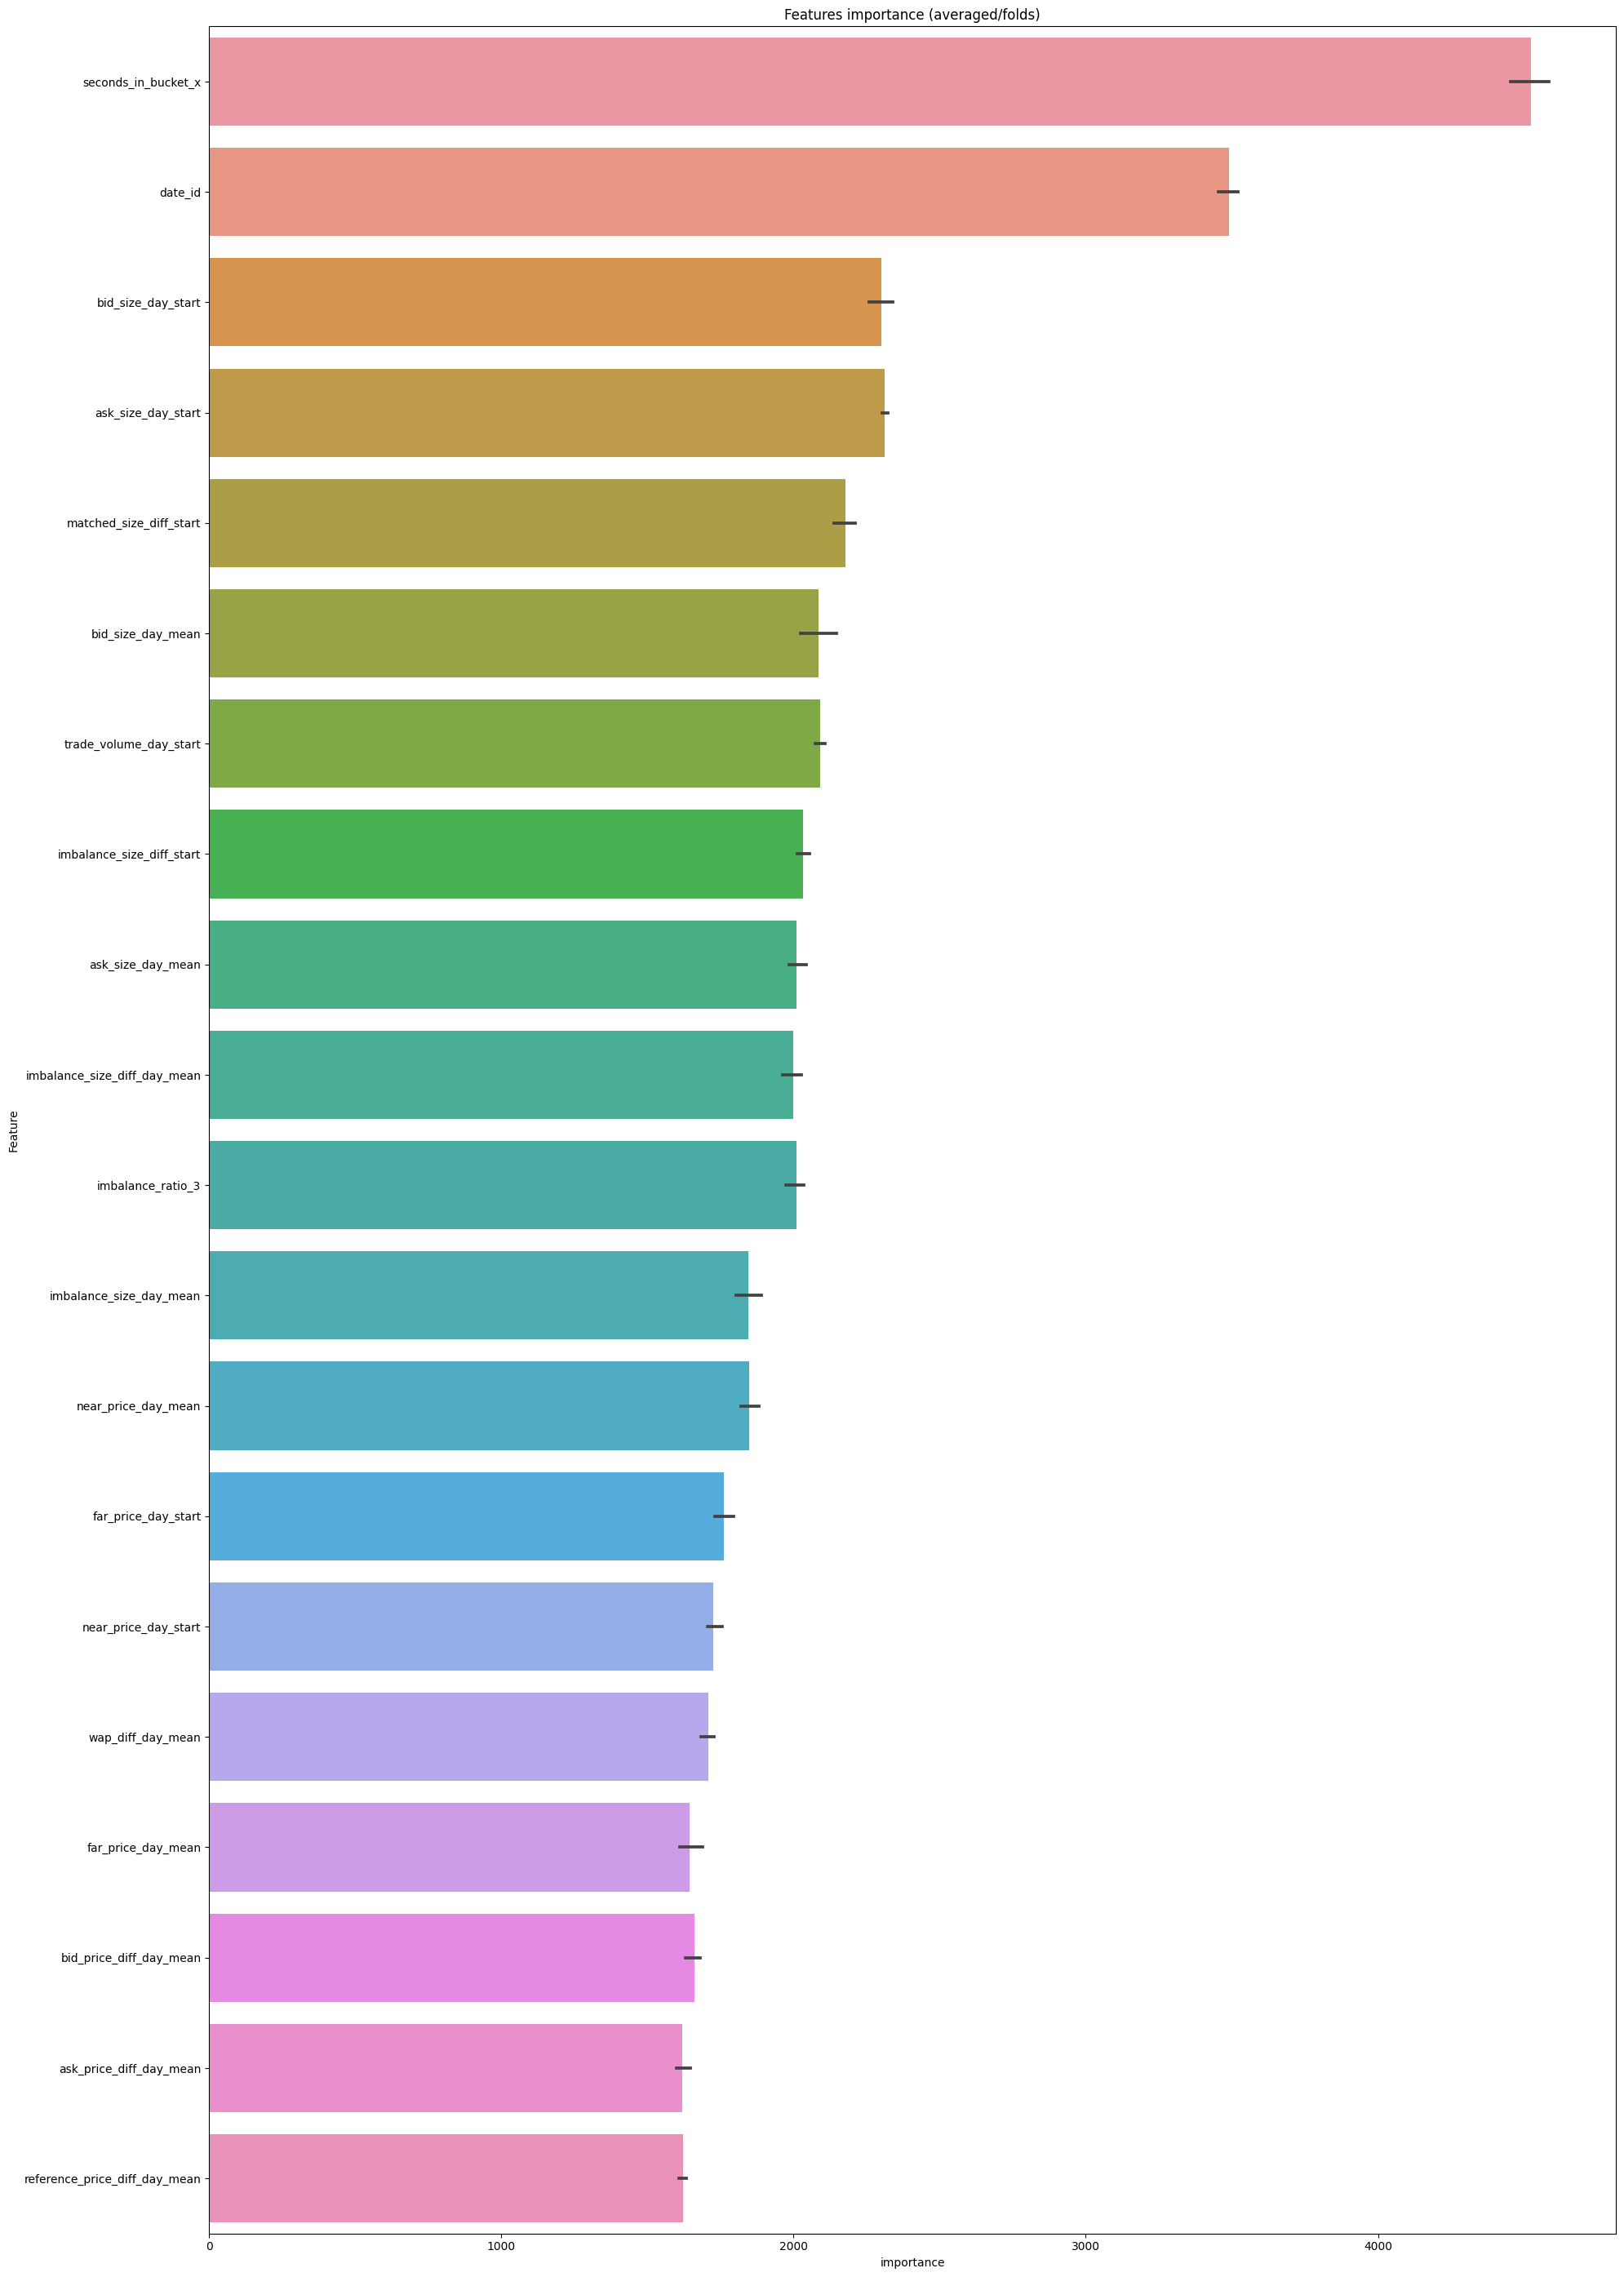

In [9]:
if is_train:
    # plot feature importance, feature selection
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:20].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(20,28))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()

# Inference mode

In [10]:
def zero_sum(prices, volumes):
    std_error = np.sqrt(volumes)
    step = np.sum(prices) / np.sum(std_error)
    out = prices - std_error * step
    return out

if is_infer:
    import optiver2023
    env = optiver2023.make_env()
    iter_test = env.iter_test()
    counter = 0
    y_min, y_max = -64, 64
    qps, predictions = [], []
    cache = pd.DataFrame()
    
    for (test, revealed_targets, sample_prediction) in iter_test:
        now_time = time.time()
        cache = pd.concat([cache, test], ignore_index=True, axis=0)
        if counter == 0:
            print(test.columns)
        if counter > 0:
            cache = cache.groupby(['stock_id']).tail(21).sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id']).reset_index(drop=True)
        feat = feature_eng(cache)[-len(test):]

        # added after new API, reference: https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/455690#2526672
        if test.currently_scored.iloc[0]== False:
            sample_prediction['target'] = 0
            env.predict(sample_prediction)
            counter += 1
            qps.append(time.time() - now_time)
            if counter % 10 == 0:
                print(counter, 'qps:', np.mean(qps))
            continue

        feat = feat.drop(columns = ["currently_scored"])    
        # end of new codes for new API
        
        # Generate predictions for each model and calculate the weighted average
        lgb_predictions = reg.predict(feat)

        lgb_predictions = zero_sum(lgb_predictions, test['bid_size'] + test['ask_size'])
        clipped_predictions = np.clip(lgb_predictions, y_min, y_max)
        sample_prediction['target'] = clipped_predictions
        env.predict(sample_prediction)
        counter += 1
        qps.append(time.time() - now_time)
        if counter % 10 == 0:
            print(counter, 'qps:', np.mean(qps))

    time_cost = 1.146 * np.mean(qps)
    print(f"The code will take approximately {np.round(time_cost, 4)} hours to reason about")
    

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'row_id', 'currently_scored'],
      dtype='object')
10 qps: 0.06290857791900635
20 qps: 0.062084662914276126
30 qps: 0.06214548746744792
40 qps: 0.0627016544342041
50 qps: 0.06252768039703369
60 qps: 0.06236926714579264
70 qps: 0.062228209631783625
80 qps: 0.0622711181640625
90 qps: 0.06386170122358534
100 qps: 0.06369032859802246
110 qps: 0.06352578726681796
120 qps: 0.06346344153086345
130 qps: 0.06335350550138033
140 qps: 0.06332675899778094
150 qps: 0.06324546496073405
160 qps: 0.0631637379527092
The code will take approximately 0.0723 hours to reason about
